# Unsloth LoRA Fine-tuning (Gen Z Chatbot)


In [18]:

import importlib

required = [
    'unsloth',
    'trl',
    'datasets',
    'accelerate',
    'bitsandbytes',
    'peft',
    'wandb',
    'dotenv',
]

missing = []
for pkg in required:
    try:
        importlib.import_module(pkg)
    except Exception:
        missing.append(pkg)

if missing:
    raise ImportError(
        f"Missing packages: {missing}. Install with: uv add {' '.join(missing)}"
    )

print("All required packages are available.")

All required packages are available.


In [19]:
import os
from pathlib import Path
import torch
import wandb
from dotenv import load_dotenv
from datasets import load_dataset
from trl import SFTConfig, SFTTrainer
from unsloth import FastLanguageModel
from transformers import TrainerCallback
import builtins
import wandb
import transformers.trainer as hf_trainer_mod
import transformers.integrations.integration_utils as hf_integration_utils
import trl.trainer.base_trainer as trl_base_trainer
load_dotenv()

print('CUDA available:', torch.cuda.is_available())
if torch.cuda.is_available():
    print('GPU:', torch.cuda.get_device_name(0))
    print('bf16 supported:', torch.cuda.is_bf16_supported())

CUDA available: True
GPU: NVIDIA GeForce RTX 3090
bf16 supported: True


In [ ]:
BASE_MODEL = 'unsloth/tinyllama'
# BASE_MODEL = 'unsloth/Phi-3.5-mini-instruct-bnb-4bit'
#BASE_MODEL = 'unsloth/Meta-Llama-3.1-8B-Instruct-bnb-4bit'

DATA_PATH = Path('genz_dataset.jsonl')
OUTPUT_DIR = 'outputs/unsloth-genz-lora-tinyllama-3'
MERGED_DIR = 'outputs/unsloth-genz-merged-tinyllama-3'

MAX_SEQ_LEN = 1024
BATCH_SIZE = 2
GRAD_ACCUM = 4
EPOCHS = 2
LR = 1e-4
SEED = 3407

template_without_answer = '<|startoftext|><|im_start|>user\n{question}<|im_end|>\n<|im_start|>assistant\n'
template_with_answer = template_without_answer + '{answer}<|im_end|>\n'

assert DATA_PATH.exists(), f'Missing dataset: {DATA_PATH}. Run gen_data.py first.'
print('Using dataset:', DATA_PATH)

Using dataset: genz_dataset.jsonl


In [21]:
model, tokenizer = FastLanguageModel.from_pretrained(
    model_name=BASE_MODEL,
    max_seq_length=MAX_SEQ_LEN,
    dtype=None,
    load_in_4bit=True,
)

model = FastLanguageModel.get_peft_model(
    model,
    r=16,
    target_modules=['q_proj', 'k_proj', 'v_proj', 'o_proj', 'gate_proj', 'up_proj', 'down_proj'],
    lora_alpha=16,
    lora_dropout=0.0,
    bias='none',
    use_gradient_checkpointing='unsloth',
    random_state=SEED,
    use_rslora=False,
    loftq_config=None,
)
model.print_trainable_parameters()

==((====))==  Unsloth 2026.2.1: Fast Llama patching. Transformers: 4.57.6.
   \\   /|    NVIDIA GeForce RTX 3090. Num GPUs = 1. Max memory: 23.559 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.10.0+cu128. CUDA: 8.6. CUDA Toolkit: 12.8. Triton: 3.6.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.34. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!
trainable params: 12,615,680 || all params: 1,112,664,064 || trainable%: 1.1338


In [22]:
raw = load_dataset('json', data_files=str(DATA_PATH), split='train')
print('rows:', len(raw), 'columns:', raw.column_names)

def format_batch(examples):
    texts = []
    for q, a in zip(examples['instruction'], examples['output']):
        texts.append(template_with_answer.format(question=q, answer=a))
    return {'text': texts}

dataset = raw.map(format_batch, batched=True, remove_columns=raw.column_names)
splits = dataset.train_test_split(test_size=0.1, seed=SEED)
train_ds = splits['train']
eval_ds = splits['test']
print('train:', len(train_ds), 'eval:', len(eval_ds))
print('sample text:\n', train_ds[0]['text'][:300])

rows: 1999 columns: ['instruction', 'output']
train: 1799 eval: 200
sample text:
 <|startoftext|><|im_start|>user
Which soccer player has the most number of career goals?<|im_end|>
<|im_start|>assistant
Cristiano Ronaldo’s the GOAT with the most career goals ever—834 and still going strong, literally. He’s still out there killing it in the pro soccer scene. Lionel Messi’s right b


In [23]:
FastLanguageModel.for_inference(model)

def chat(question, max_new_tokens=96, temperature=0.8):
    prompt = template_without_answer.format(question=question)
    inputs = tokenizer(prompt, return_tensors='pt').to(model.device)
    with torch.no_grad():
        out = model.generate(
            **inputs,
            max_new_tokens=max_new_tokens,
            do_sample=True,
            temperature=temperature,
            top_p=0.9,
        )
    text = tokenizer.decode(out[0], skip_special_tokens=False)
    if '<|im_start|>assistant\n' in text:
        text = text.split('<|im_start|>assistant\n', 1)[1]
    if '<|im_end|>' in text:
        text = text.split('<|im_end|>', 1)[0]
    return text.strip()

probe_qs = [
    'What should I do if I am tired all day?',
    'Give me a one-day study plan before an exam.',
    'How do I politely reject an invitation?'
]

print('=== Before fine-tuning ===')
for q in probe_qs:
    print('Q:', q)
    print('A:', chat(q))
    print('-' * 80)

=== Before fine-tuning ===
Q: What should I do if I am tired all day?
A: 
--------------------------------------------------------------------------------
Q: Give me a one-day study plan before an exam.
A: 1. The number of hours a student spends in the library per week during the fall and spring semesters.
2. The number of hours a student spends in the library per week during the summer session.
3. The number of hours a student spends in the library per week during the spring semester.
4. The number of hours a student spends in the library per week during the fall, spring and summer sessions.
5. The number
--------------------------------------------------------------------------------
Q: How do I politely reject an invitation?
A: What is the point of the second sentence?
What are the two main purposes of the sentence?
What are the 4 parts of speech for the sentence?
The sentence is the subject of the sentence.
The sentence is the object of the sentence.
The subject is the person or th

In [24]:
class LossPrinterCallback(TrainerCallback):
    def on_log(self, args, state, control, logs=None, **kwargs):
        if not logs:
            return
        if 'loss' in logs and state.global_step % 10 == 0:
            print(f"step {state.global_step} | loss: {logs['loss']:.4f}")
        if 'eval_loss' in logs and state.global_step % 10 == 0:
            print(f"step {state.global_step} | eval_loss: {logs['eval_loss']:.4f}")


builtins.wandb = wandb
hf_trainer_mod.wandb = wandb
hf_integration_utils.wandb = wandb
trl_base_trainer.wandb = wandb

wandb_api_key = os.getenv('WANDB_API_KEY', '').strip()
wandb_project = os.getenv('WANDB_PROJECT', 'genz-speak').strip() or 'genz-speak'
if not wandb_api_key:
    raise EnvironmentError('WANDB_API_KEY is missing. Add it to .env and re-run from Cell 2.')

wandb.login(key=wandb_api_key, relogin=True)
wandb.init(
    project=wandb_project,
    name=f"unsloth-{BASE_MODEL.split('/')[-1]}",
    config={
        'base_model': BASE_MODEL,
        'max_seq_len': MAX_SEQ_LEN,
        'batch_size': BATCH_SIZE,
        'grad_accum': GRAD_ACCUM,
        'epochs': EPOCHS,
        'learning_rate': LR,
        'seed': SEED,
    },
)

sft_args = SFTConfig(
    output_dir=OUTPUT_DIR,
    num_train_epochs=EPOCHS,
    max_steps=-1,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    gradient_accumulation_steps=GRAD_ACCUM,
    learning_rate=LR,
    optim='adamw_8bit',
    lr_scheduler_type='cosine',
    warmup_ratio=0.05,
    weight_decay=0.01,
    max_grad_norm=1.0,
    logging_steps=10,
    save_strategy='steps',
    save_steps=100,
    eval_strategy='steps',
    eval_steps=100,
    save_total_limit=2,
    fp16=not torch.cuda.is_bf16_supported(),
    bf16=torch.cuda.is_bf16_supported(),
    dataloader_num_workers=0,
    report_to='wandb',
    run_name=f"{BASE_MODEL.split('/')[-1]}",
    seed=SEED,
)

try:
    trainer = SFTTrainer(
        model=model,
        processing_class=tokenizer,
        train_dataset=train_ds,
        eval_dataset=eval_ds,
        dataset_text_field='text',
        max_seq_length=MAX_SEQ_LEN,
        packing=False,
        args=sft_args,
    )
except TypeError:
    trainer = SFTTrainer(
        model=model,
        tokenizer=tokenizer,
        train_dataset=train_ds,
        eval_dataset=eval_ds,
        dataset_text_field='text',
        max_seq_length=MAX_SEQ_LEN,
        packing=False,
        args=sft_args,
    )

trainer.add_callback(LossPrinterCallback())
train_result = trainer.train()
print(train_result.metrics)
wandb.finish()

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: WARNING [wandb.login()] Changing session credentials to explicit value for https://api.wandb.ai.
wandb: Appending key for api.wandb.ai to your netrc file: /home/martin/.netrc


==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 1,799 | Num Epochs = 2 | Total steps = 450
O^O/ \_/ \    Batch size per device = 2 | Gradient accumulation steps = 4
\        /    Data Parallel GPUs = 1 | Total batch size (2 x 4 x 1) = 8
 "-____-"     Trainable parameters = 12,615,680 of 1,112,664,064 (1.13% trained)


Unsloth: Will smartly offload gradients to save VRAM!


Step,Training Loss,Validation Loss
100,1.600700,1.526318
200,1.441000,1.440528
300,1.385000,1.420367
400,1.410900,1.413323


step 10 | loss: 3.6278
step 20 | loss: 3.2518
step 30 | loss: 2.4736
step 40 | loss: 1.9927
step 50 | loss: 1.8805
step 60 | loss: 1.7462
step 70 | loss: 1.6199
step 80 | loss: 1.6456
step 90 | loss: 1.6358
step 100 | loss: 1.6007
step 100 | eval_loss: 1.5263
step 110 | loss: 1.5713
step 120 | loss: 1.5615
step 130 | loss: 1.5853
step 140 | loss: 1.5784
step 150 | loss: 1.4915
step 160 | loss: 1.4996
step 170 | loss: 1.5678
step 180 | loss: 1.4595
step 190 | loss: 1.4571
step 200 | loss: 1.4410
step 200 | eval_loss: 1.4405
step 210 | loss: 1.4710
step 220 | loss: 1.5319
step 230 | loss: 1.3633
step 240 | loss: 1.4009
step 250 | loss: 1.4545
step 260 | loss: 1.3771
step 270 | loss: 1.3485
step 280 | loss: 1.3891
step 290 | loss: 1.3555
step 300 | loss: 1.3850
step 300 | eval_loss: 1.4204
step 310 | loss: 1.3483
step 320 | loss: 1.3735
step 330 | loss: 1.3611
step 340 | loss: 1.3948
step 350 | loss: 1.4612
step 360 | loss: 1.5148
step 370 | loss: 1.3965
step 380 | loss: 1.4768
step 390 |

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


eval/loss,█▃▁▁
eval/runtime,▁▃▂█
eval/samples_per_second,█▆▇▁
eval/steps_per_second,█▆▇▁
train/epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
train/global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇████
train/grad_norm,█▄▄▂▂▂▂▁▁▁▁▂▁▁▁▁▂▁▂▂▁▂▂▂▂▁▂▂▂▁▂▁▂▂▁▂▁▁▂▂
train/learning_rate,▄▇██████▇▇▇▇▇▇▆▆▆▅▅▅▅▄▄▄▃▃▃▃▃▂▂▂▂▁▁▁▁▁▁▁
train/loss,█▇▄▃▃▂▂▂▂▂▂▂▂▁▁▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
eval/loss,1.41332
eval/runtime,4.3574


{'train_runtime': 291.4203, 'train_samples_per_second': 12.346, 'train_steps_per_second': 1.544, 'total_flos': 4497293568024576.0, 'train_loss': 1.5955372704399957, 'epoch': 2.0}


In [25]:
# ===== Save adapter + merged model =====
trainer.model.save_pretrained(OUTPUT_DIR)
tokenizer.save_pretrained(OUTPUT_DIR)
trainer.model.save_pretrained_merged(MERGED_DIR, tokenizer, save_method='merged_16bit')
print('Saved LoRA adapter to:', OUTPUT_DIR)
print('Saved merged model to:', MERGED_DIR)

Found HuggingFace hub cache directory: /home/martin/.cache/huggingface/hub
Checking cache directory for required files...
Cache check failed: model.safetensors not found in local cache.
Not all required files found in cache. Will proceed with downloading.
Checking cache directory for required files...
Cache check failed: tokenizer.model not found in local cache.
Not all required files found in cache. Will proceed with downloading.


Unsloth: Merging weights into 16bit: 100%|██████████| 1/1 [00:03<00:00,  3.43s/it]


Unsloth: Merge process complete. Saved to `/home/martin/dev/genz_speak/outputs/unsloth-genz-merged-tinyllama-3`
Saved LoRA adapter to: outputs/unsloth-genz-lora-tinyllama-3
Saved merged model to: outputs/unsloth-genz-merged-tinyllama-3


In [26]:
FastLanguageModel.for_inference(model)

def ask_model(question, max_new_tokens=128, temperature=0.8):
    prompt = template_without_answer.format(question=question)
    inputs = tokenizer(prompt, return_tensors='pt').to(model.device)
    with torch.no_grad():
        out = model.generate(
            **inputs,
            max_new_tokens=max_new_tokens,
            do_sample=True,
            temperature=temperature,
            top_p=0.9,
        )
    text = tokenizer.decode(out[0], skip_special_tokens=False)
    if '<|im_start|>assistant\n' in text:
        text = text.split('<|im_start|>assistant\n', 1)[1]
    if '<|im_end|>' in text:
        text = text.split('<|im_end|>', 1)[0]
    return text.strip()

my_question = 'Explain black holes in simple terms.'
print('Q:', my_question)
print('A:', ask_model(my_question, max_new_tokens=140, temperature=0.75))

Q: Explain black holes in simple terms.
A: so like, black holes are basically the ultimate energy and gravity energy levels. they're so dense and packed with stuff that light can't even get through, so they can totally absorb stuff and pull it in. they're kinda like a black hole in space, but instead of gravity, it's the dark stuff. the whole thing is so wild, and scientists are still figuring out how they work, but they can totally make stuff disappear. like, when light gets sucked in, it turns into a black hole. then the black hole spits stuff out like waves, but they're so big they can even pull stuff in from outside


In [ ]:
my_question = 'Who directed the Lord of the Rings?'
print('Q:', my_question)
print('A:', ask_model(my_question, max_new_tokens=140, temperature=0.75))

Q: Who directed the Lord of the Rings?
A: Ron Howard? Yeah, he totally directed all three Lord of the Rings movies—The Fellowship of the Ring, The Two Towers, and The Return of the King, which is straight-up iconic. The director also directed The Da Vinci Code, which is a whole thing. Like, he7s basically the OG behind some of the most iconic movies ever made.


: 

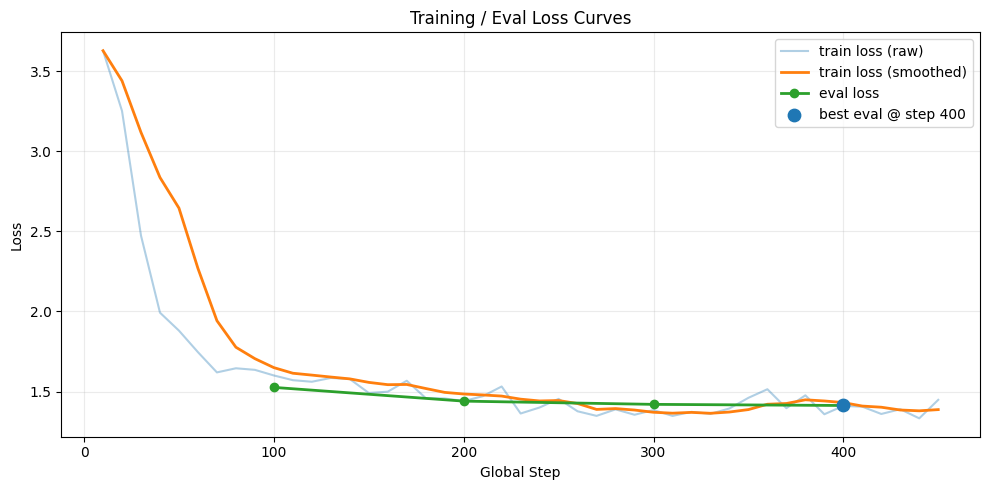

In [27]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

history = pd.DataFrame(trainer.state.log_history)

if history.empty:
    raise ValueError("No trainer logs found. Make sure training cell finished successfully.")

cols = [c for c in ["step", "loss", "eval_loss", "learning_rate", "epoch"] if c in history.columns]
h = history[cols].copy()

train_curve = h.dropna(subset=["loss"])[["step", "loss"]].drop_duplicates("step")
eval_curve = h.dropna(subset=["eval_loss"])[["step", "eval_loss"]].drop_duplicates("step")

if len(train_curve) >= 5:
    train_curve["loss_smooth"] = train_curve["loss"].rolling(5, min_periods=1).mean()
else:
    train_curve["loss_smooth"] = train_curve["loss"]

plt.figure(figsize=(10, 5))
plt.plot(train_curve["step"], train_curve["loss"], alpha=0.35, label="train loss (raw)")
plt.plot(train_curve["step"], train_curve["loss_smooth"], linewidth=2, label="train loss (smoothed)")

if not eval_curve.empty:
    plt.plot(eval_curve["step"], eval_curve["eval_loss"], marker="o", linewidth=2, label="eval loss")
    best_idx = eval_curve["eval_loss"].idxmin()
    best_step = int(eval_curve.loc[best_idx, "step"])
    best_eval = float(eval_curve.loc[best_idx, "eval_loss"])
    plt.scatter([best_step], [best_eval], s=80, zorder=5, label=f"best eval @ step {best_step}")

plt.title("Training / Eval Loss Curves")
plt.xlabel("Global Step")
plt.ylabel("Loss")
plt.grid(alpha=0.25)
plt.legend()
plt.tight_layout()
plt.show()